__Structured Output__:  
Refers to models returning responses in a structured format (for example json) rather than free text

Where can this be used?
- Data extraction
- API building
- Multi agents 

There are two types of LLMs: 
1. Can generate structured output if asked  
In langchain we have `with_structured_output` for this task
2. Cannot generate structured output even if asked  
`Output parsers` are used

3 output formats we gonna need
- TypedDict
- Pydantic
- JSON

## with_structured_output
- We define a schema and give it to the function 
- This function rewrites the prompt to demand the given schema from llm
- It let the model generate its output and then try to Parse and validate it
- If response doesnt fit schema, then retry with error feedback  

### TypedDict  
A way to define a dictionary in which we specify what keys and values should exist. Note- TypedDict does not validate the dictionary, that means even if we give wrong values to dictionary it wont give error

In [2]:
# Example
from typing import TypedDict

class Person(TypedDict):
    name: str
    age: int

person1 = Person(name='Arun',age='19')
person1

{'name': 'Arun', 'age': '19'}

In [1]:
from typing import TypedDict, Annotated, Optional, Literal
from dotenv import load_dotenv
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint

#A text of someone reviewing something
review1 = """
I recently upgraded to the Samsung Galaxy S24 Ultra, and I must say, it’s an absolute powerhouse! The Snapdragon 8 Gen 3 processor makes everything lightning fast—whether I’m gaming, multitasking, or editing photos. The 5000mAh battery easily lasts a full day even with heavy use, and the 45W fast charging is a lifesaver.

The S-Pen integration is a great touch for note-taking and quick sketches, though I don't use it often. What really blew me away is the 200MP camera—the night mode is stunning, capturing crisp, vibrant images even in low light. Zooming up to 100x actually works well for distant objects, but anything beyond 30x loses quality.

However, the weight and size make it a bit uncomfortable for one-handed use. Also, Samsung’s One UI still comes with bloatware—why do I need five different Samsung apps for things Google already provides? The $1,300 price tag is also a hard pill to swallow.

Pros:
Insanely powerful processor (great for gaming and productivity)
Stunning 200MP camera with incredible zoom capabilities
Long battery life with fast charging
S-Pen support is unique and useful

Review by Nitish Singh           
"""

#Define format
class Review(TypedDict):
    summary: Annotated[str, 'A breif summary of review']
    sentiment:Annotated[Literal['Negative','Positive','Neutral'],'Classify sentiment into one of - Negative, Positive, Neutral']
    name: Annotated[Optional[str], 'Write down the name of person reviewing,(only if the name is mentioned)']


load_dotenv()

llm = HuggingFaceEndpoint(
    repo_id="deepseek-ai/DeepSeek-V3.2",
    verbose=True
)
model = ChatHuggingFace(llm=llm)

#Give that format to model
structured_model = model.with_structured_output(Review)


#Give that review to structured_model for summary and sentiment 
result = structured_model.invoke(review1)

In [3]:
print(type(result))
result

<class 'dict'>


{'name': 'Nitish Singh',
 'sentiment': 'Positive',
 'summary': "The review praises the Samsung Galaxy S24 Ultra's powerful processor, excellent camera with great zoom, long battery life, and useful S-Pen, while noting its large size, pre-installed software, and high price."}

### Pydantic
A data validation and data parsing library in python that ensures the data we work with is  correct, structure, and type safe

_`So the thing is that, HF does not support structured output in pydantic model, And the reason is a bit complex so ill check it out later properly (i hope so)`_

Checked it out hehe, Its cause many models do not support .with_structured_output with `method=function_calling` instead then use `method=json_schema` 

(This works only for models that can give structured output, if the model CANNOT give structured output then we use output parsers)

For now lets use gemini

In [6]:
from pydantic import BaseModel, Field
from langchain_google_genai import ChatGoogleGenerativeAI

review1 = """
I recently upgraded to the Samsung Galaxy S24 Ultra, and I must say, it’s an absolute powerhouse! The Snapdragon 8 Gen 3 processor makes everything lightning fast—whether I’m gaming, multitasking, or editing photos. The 5000mAh battery easily lasts a full day even with heavy use, and the 45W fast charging is a lifesaver.

The S-Pen integration is a great touch for note-taking and quick sketches, though I don't use it often. What really blew me away is the 200MP camera—the night mode is stunning, capturing crisp, vibrant images even in low light. Zooming up to 100x actually works well for distant objects, but anything beyond 30x loses quality.

However, the weight and size make it a bit uncomfortable for one-handed use. Also, Samsung’s One UI still comes with bloatware—why do I need five different Samsung apps for things Google already provides? The $1,300 price tag is also a hard pill to swallow.

Pros:
Insanely powerful processor (great for gaming and productivity)
Stunning 200MP camera with incredible zoom capabilities
Long battery life with fast charging
S-Pen support is unique and useful

Review by Nitish Singh           
"""

#Define format
class Review(BaseModel):
    summary: str = Field(description="A breif summary of review")
    sentiment: Literal['Positive','Negative','Neutral'] = Field(description="Classify the review in three classes 'Positive', 'Negative','Neutral'")
    name: Optional[str] = Field(default=None,description="Give the name of reviewer if specifically mentioned")

load_dotenv()

model = ChatGoogleGenerativeAI(model="gemini-2.5-flash")


structured_model = model.with_structured_output(Review)



result = structured_model.invoke(review1)

In [12]:
print(type(result))
print(result)

<class '__main__.Review'>
summary='The Samsung Galaxy S24 Ultra is a powerful phone with a Snapdragon 8 Gen 3 processor, 200MP camera, long-lasting 5000mAh battery with 45W fast charging, and S-Pen support. However, it is heavy and large, comes with bloatware, and has a high price.' sentiment='Positive' name='Nitish Singh'


### JSON
JSON is useful when we are working with multiple languages since this is compatible with all programming languages

json schema looks like this: 

```json
{
    "title": "student",
    "description": "Schema about students",
    "type": "object",
    "properties": {
        "name": "string",
        "age": "integer"
    },
    "required": ["Name"]
}

In [16]:
json_schema = {
    "title": "Review",
    "description": "Review of products",
    "type": "object",
    "properties": {
        "summary": {
            "type":"string",
            "description":"A breif summary of review"
        },
        "sentiment": {
            "type": "string",
            "enum":["positive","negative","neutral"],
            "description": "Classify the review in 'Positive','Negative','Neutral'."
        },
        "name": {
            "type": "string",
            "description": "Give the name of REVIEWER (if specified in review)"
        }
    }, 
    "required": ["summary","sentiment"]
}

review1 = """
I recently upgraded to the Samsung Galaxy S24 Ultra, and I must say, it’s an absolute powerhouse! The Snapdragon 8 Gen 3 processor makes everything lightning fast—whether I’m gaming, multitasking, or editing photos. The 5000mAh battery easily lasts a full day even with heavy use, and the 45W fast charging is a lifesaver.

The S-Pen integration is a great touch for note-taking and quick sketches, though I don't use it often. What really blew me away is the 200MP camera—the night mode is stunning, capturing crisp, vibrant images even in low light. Zooming up to 100x actually works well for distant objects, but anything beyond 30x loses quality.

However, the weight and size make it a bit uncomfortable for one-handed use. Also, Samsung’s One UI still comes with bloatware—why do I need five different Samsung apps for things Google already provides? The $1,300 price tag is also a hard pill to swallow.

Pros:
Insanely powerful processor (great for gaming and productivity)
Stunning 200MP camera with incredible zoom capabilities
Long battery life with fast charging
S-Pen support is unique and useful

Review by Nitish Singh           
"""

llm = HuggingFaceEndpoint(
    repo_id="deepseek-ai/DeepSeek-V3.2"
)

model = ChatHuggingFace(llm=llm)

structured_model = model.with_structured_output(schema=json_schema)
result = structured_model.invoke(review1)

In [17]:
print(type(result))
result

<class 'dict'>


{'name': 'Nitish Singh',
 'sentiment': 'positive',
 'summary': 'A powerful phone with a fast processor, excellent 200MP camera with good zoom, long battery life, and useful S-Pen, but criticized for its large size, pre-installed bloatware, and high price.'}

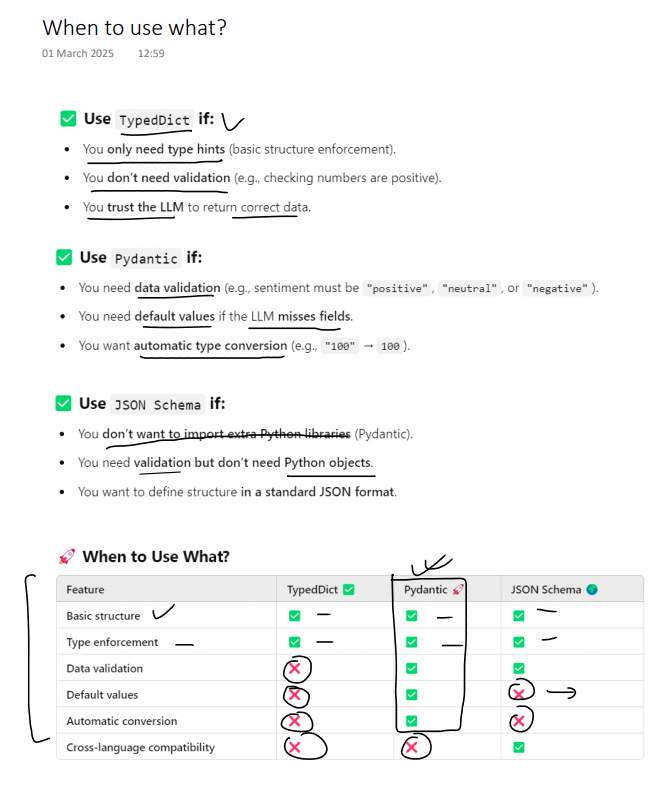

In [19]:
review1 = """
I recently upgraded to the Samsung Galaxy S24 Ultra, and I must say, it’s an absolute powerhouse! The Snapdragon 8 Gen 3 processor makes everything lightning fast—whether I’m gaming, multitasking, or editing photos. The 5000mAh battery easily lasts a full day even with heavy use, and the 45W fast charging is a lifesaver.

The S-Pen integration is a great touch for note-taking and quick sketches, though I don't use it often. What really blew me away is the 200MP camera—the night mode is stunning, capturing crisp, vibrant images even in low light. Zooming up to 100x actually works well for distant objects, but anything beyond 30x loses quality.

However, the weight and size make it a bit uncomfortable for one-handed use. Also, Samsung’s One UI still comes with bloatware—why do I need five different Samsung apps for things Google already provides? The $1,300 price tag is also a hard pill to swallow.

Pros:
Insanely powerful processor (great for gaming and productivity)
Stunning 200MP camera with incredible zoom capabilities
Long battery life with fast charging
S-Pen support is unique and useful

Review by Nitish Singh           
"""

#Define format
class Review(BaseModel):
    summary: str = Field(description="A breif summary of review")
    sentiment: Literal['Positive','Negative','Neutral'] = Field(description="Classify the review in three classes 'Positive', 'Negative','Neutral'")
    name: Optional[str] = Field(default=None,description="Give the name of reviewer if specifically mentioned")

load_dotenv()

llm = HuggingFaceEndpoint(
    repo_id="deepseek-ai/DeepSeek-V3.2"
)

model = ChatHuggingFace(llm=llm)

# This will give error
# structured_model = model.with_structured_output(Review)

structured_model = model.with_structured_output(Review,method="json_schema")

In [20]:
result = structured_model.invoke(review1)

In [21]:
print(type(result))
result

<class 'dict'>


{'product': 'Samsung Galaxy S24 Ultra',
 'reviewer': 'Nitish Singh',
 'sentiment': 'Mostly Positive',
 'summary': "The reviewer praises the phone's performance, battery life, and camera capabilities, but criticizes its size, pre-installed software, and high price.",
 'key_highlights': ['Snapdragon 8 Gen 3 processor provides excellent performance for gaming and multitasking.',
  '5000mAh battery lasts a full day with heavy use, supported by 45W fast charging.',
  '200MP camera excels, especially in night mode and with zoom capabilities up to 30x.',
  'S-Pen integration is noted as a unique and useful feature for note-taking and sketches.'],
 'criticisms': ["The phone's weight and size make one-handed use uncomfortable.",
  'Pre-installed Samsung apps (bloatware) are considered redundant alongside Google services.',
  'The $1,300 price tag is viewed as very high.',
  'Camera zoom quality significantly degrades beyond 30x.']}